In [3]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds

In [4]:
from pathlib import Path

if Path("helper_functions.py").exists():
  print("File already exists no need to download :D .")
else:
  print("Downloading Files")
  !wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

from helper_functions import create_tensorboard_callback, plot_loss_curves, compare_historys

--2025-01-21 10:50:47--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2025-01-21 10:50:47 (71.3 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [5]:
list_datasets = tfds.list_builders()

target_dataset = "food101"

print(f"{target_dataset} is in Tensorflow Datasets : {target_dataset in list_datasets}")

food101 is in Tensorflow Datasets : True


In [5]:
(train_data, test_data), ds_info = tfds.load(name="food101",
                                             split=["train", "validation"],
                                             shuffle_files=True,
                                             as_supervised=True,
                                             with_info=True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

KeyboardInterrupt: 

In [7]:
ds_info.features

FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=uint8),
    'label': ClassLabel(shape=(), dtype=int64, num_classes=101),
})

In [31]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [8]:
saved_model_path = Path("/content/drive/MyDrive/FoodVision/FoodVisionFE.keras")

saved_model_path.exists()

True

In [9]:
load_fe_model = tf.keras.models.load_model(saved_model_path)

/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'adam', because it has 6 variables whereas the saved optimizer has 10 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [10]:
load_fe_model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ efficientnetv2-b0 (Functional)       │ (None, 7, 7, 1280)          │       5,919,312 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ pooling_layer                        │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 101)                 │         129,381 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ cast_3 (Cast)                        │ (None, 101)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ output_layer (Activation)            │ (None, 101)                 │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 6,307,457 (24.06 MB)

 Trainable params: 129,381 (505.39 KB)

 Non-trainable params: 5,919,312 (22.58 MB)

 Optimizer params: 258,764 (1010.80 KB)

In [11]:
load_fe_model.layers

[<InputLayer name=input_layer, built=True>,
 <Functional name=efficientnetv2-b0, built=True>,
 <GlobalAveragePooling2D name=pooling_layer, built=True>,
 <Dense name=dense, built=True>,
 <Activation name=output_layer, built=True>]

In [12]:
class_names = ds_info.features["label"].names
class_names[:10]

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito']

In [13]:
from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy(policy="mixed_float16")

In [14]:
mixed_precision.global_policy()

<DTypePolicy "mixed_float16">

In [15]:
def preprocess_img(image, label, img_shape=224):

  image = tf.image.resize(image, [img_shape, img_shape])

  return tf.cast(image, tf.float32), label


In [16]:
train_data = train_data.map(map_func=preprocess_img, num_parallel_calls=tf.data.AUTOTUNE)

train_data = train_data.shuffle(buffer_size=1000).batch(batch_size=32).prefetch(buffer_size=tf.data.AUTOTUNE)

test_data = test_data.map(map_func=preprocess_img, num_parallel_calls=tf.data.AUTOTUNE)

test_data = test_data.batch(32).prefetch(buffer_size=tf.data.AUTOTUNE)

train_data, test_data

(<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>,
 <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>)

In [17]:
load_fe_model.evaluate(test_data)

790/790 ━━━━━━━━━━━━━━━━━━━━ 74s 72ms/step - accuracy: 0.7156 - loss: 1.0553


[1.0551525354385376, 0.7160395979881287]

In [19]:
for layer in load_fe_model.layers:
  layer.trainable = True
  print(f"Name: {layer.name} | Dtype: {layer.dtype} | MixedPrecision: {layer.dtype_policy} | Trainable: {layer.trainable}")

Name: input_layer | Dtype: float32 | MixedPrecision: <DTypePolicy "float32"> | Trainable: True
Name: efficientnetv2-b0 | Dtype: float32 | MixedPrecision: <DTypePolicy "float32"> | Trainable: True
Name: pooling_layer | Dtype: float32 | MixedPrecision: <DTypePolicy "mixed_float16"> | Trainable: True
Name: dense | Dtype: float32 | MixedPrecision: <DTypePolicy "mixed_float16"> | Trainable: True
Name: output_layer | Dtype: float32 | MixedPrecision: <DTypePolicy "float32"> | Trainable: True


In [20]:
for layer in load_fe_model.layers[1].layers[:20]:
  print(layer.name, layer.trainable, layer.dtype, layer.dtype_policy)

input_layer_1 True float32 <DTypePolicy "float32">
rescaling_1 True float32 <DTypePolicy "mixed_float16">
normalization_1 True float32 <DTypePolicy "mixed_float16">
stem_conv True float32 <DTypePolicy "mixed_float16">
stem_bn True float32 <DTypePolicy "mixed_float16">
stem_activation True float32 <DTypePolicy "mixed_float16">
block1a_project_conv True float32 <DTypePolicy "mixed_float16">
block1a_project_bn True float32 <DTypePolicy "mixed_float16">
block1a_project_activation True float32 <DTypePolicy "mixed_float16">
block2a_expand_conv True float32 <DTypePolicy "mixed_float16">
block2a_expand_bn True float32 <DTypePolicy "mixed_float16">
block2a_expand_activation True float32 <DTypePolicy "mixed_float16">
block2a_project_conv True float32 <DTypePolicy "mixed_float16">
block2a_project_bn True float32 <DTypePolicy "mixed_float16">
block2b_expand_conv True float32 <DTypePolicy "mixed_float16">
block2b_expand_bn True float32 <DTypePolicy "mixed_float16">
block2b_expand_activation True fl

In [21]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_loss",
                                                  patience=3)

checkpoint_path = Path("/content/drive/MyDrive/FoodVision/finetune_checkpoint.keras")
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                      save_best_only=True,
                                                      monitor="val_loss")

In [22]:
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss",
                                                 factor=0.2,
                                                 patience=2,
                                                 verbose=1,
                                                 min_lr=1e-7)

In [23]:
load_fe_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                      loss="sparse_categorical_crossentropy",
                      metrics=["accuracy"])

In [24]:
mixed_precision.global_policy()

<DTypePolicy "mixed_float16">

In [28]:
history_food_101_fine_tune = load_fe_model.fit(train_data,
                                               epochs=100,
                                               validation_data=test_data,
                                               validation_steps=int(0.15 * len(test_data)),
                                               callbacks=[create_tensorboard_callback("training_logs", "efficientb0_101_classes_all_data_fine_tuning"),
                                                          model_checkpoint,
                                                          early_stopping,
                                                          reduce_lr])

Saving TensorBoard log files to: training_logs/efficientb0_101_classes_all_data_fine_tuning/20250121-102009
Epoch 1/100
2368/2368 ━━━━━━━━━━━━━━━━━━━━ 218s 90ms/step - accuracy: 0.9402 - loss: 0.2418 - val_accuracy: 0.8467 - val_loss: 0.5605 - learning_rate: 2.0000e-05
Epoch 2/100
2368/2368 ━━━━━━━━━━━━━━━━━━━━ 268s 93ms/step - accuracy: 0.9524 - loss: 0.1971 - val_accuracy: 0.8424 - val_loss: 0.5810 - learning_rate: 2.0000e-05
Epoch 3/100
2368/2368 ━━━━━━━━━━━━━━━━━━━━ 220s 91ms/step - accuracy: 0.9605 - loss: 0.1688 - val_accuracy: 0.8475 - val_loss: 0.5581 - learning_rate: 2.0000e-05


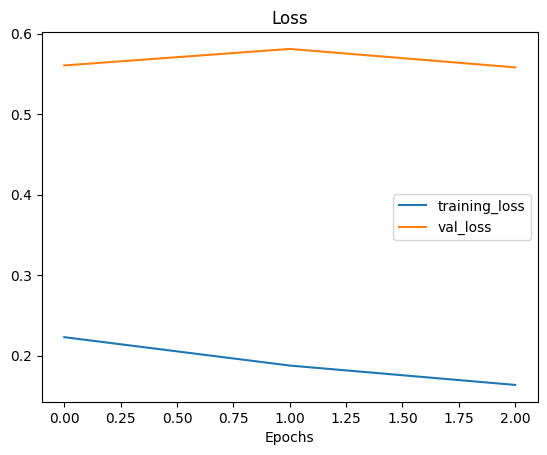

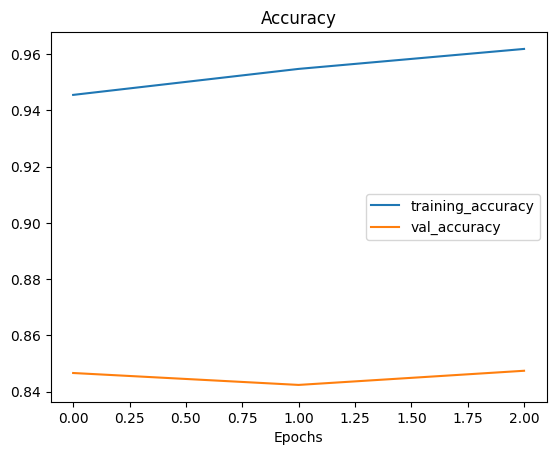

In [29]:
plot_loss_curves(history_food_101_fine_tune)

In [1]:
import tensorflow as tf

ft_model = tf.keras.models.load_model("/content/drive/MyDrive/FoodVision/finetune_checkpoint.keras")

/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'adam', because it has 488 variables whereas the saved optimizer has 492 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [18]:
ft_model.evaluate(test_data)

790/790 ━━━━━━━━━━━━━━━━━━━━ 62s 69ms/step - accuracy: 0.8371 - loss: 0.5767


[0.5784263610839844, 0.8367524743080139]

In [30]:
results_fine_tune_model = load_fe_model.evaluate(test_data)

790/790 ━━━━━━━━━━━━━━━━━━━━ 53s 66ms/step - accuracy: 0.8438 - loss: 0.5716


In [31]:
load_fe_model.save("/content/drive/MyDrive/FoodVision/FineTunedModelFood101.keras")

In [35]:
test_sample = test_data.take(1)

for image, label in test_sample:
  print(image, label)

tf.Tensor(
[[[[6.19285736e+01 5.14693871e+01 2.51581650e+01]
   [4.55918350e+01 3.77857132e+01 1.73520393e+01]
   [3.11581612e+01 2.61479588e+01 1.47908154e+01]
   ...
   [2.07857361e+01 5.78573608e+00 0.00000000e+00]
   [2.20000000e+01 7.00000000e+00 0.00000000e+00]
   [2.10000000e+01 6.00000000e+00 0.00000000e+00]]

  [[8.77908173e+01 7.30000000e+01 4.34336739e+01]
   [7.00612183e+01 5.79948997e+01 3.21938782e+01]
   [4.76275520e+01 3.93571472e+01 2.36683674e+01]
   ...
   [2.19846954e+01 6.98469543e+00 0.00000000e+00]
   [2.19285583e+01 6.92855835e+00 0.00000000e+00]
   [2.06428223e+01 5.64282227e+00 0.00000000e+00]]

  [[1.02908165e+02 8.15663223e+01 4.51326523e+01]
   [9.16989746e+01 7.41122437e+01 4.32397957e+01]
   [6.28367348e+01 5.10510216e+01 2.93112240e+01]
   ...
   [2.25969219e+01 7.16835022e+00 1.68350190e-01]
   [2.16989899e+01 6.27041864e+00 0.00000000e+00]
   [2.26428566e+01 7.21428585e+00 0.00000000e+00]]

  ...

  [[3.37857361e+01 2.67857361e+01 1.72142639e+01]
   [3

In [37]:
test_results = load_fe_model.predict(image)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step


In [58]:
image[0]

<tf.Tensor: shape=(224, 224, 3), dtype=float32, numpy=
array([[[ 61.928574  ,  51.469387  ,  25.158165  ],
        [ 45.591835  ,  37.785713  ,  17.35204   ],
        [ 31.158161  ,  26.147959  ,  14.790815  ],
        ...,
        [ 20.785736  ,   5.785736  ,   0.        ],
        [ 22.        ,   7.        ,   0.        ],
        [ 21.        ,   6.        ,   0.        ]],

       [[ 87.79082   ,  73.        ,  43.433674  ],
        [ 70.06122   ,  57.9949    ,  32.19388   ],
        [ 47.627552  ,  39.357147  ,  23.668367  ],
        ...,
        [ 21.984695  ,   6.9846954 ,   0.        ],
        [ 21.928558  ,   6.9285583 ,   0.        ],
        [ 20.642822  ,   5.6428223 ,   0.        ]],

       [[102.908165  ,  81.56632   ,  45.132652  ],
        [ 91.698975  ,  74.11224   ,  43.239796  ],
        [ 62.836735  ,  51.05102   ,  29.311224  ],
        ...,
        [ 22.596922  ,   7.16835   ,   0.16835019],
        [ 21.69899   ,   6.2704186 ,   0.        ],
        [ 22.64285

In [48]:
tf.argmax(test_results, axis=1)

<tf.Tensor: shape=(32,), dtype=int64, numpy=
array([ 42,  25,  46,  69, 100,  39,  10,  95,  16,  22,  63,  35,  36,
        66,  76,   9,  51,  56,  48,  79,  44,  81,  43,  27,  47,  46,
        22,  93,  70,  42,  90,  21])>

In [54]:
np.sum(label == tf.argmax(test_results, axis=1))

24

In [57]:
24 / 32

0.75

In [60]:
from PIL import Image

def predictions(image, model, class_names, image_shape=224, tensor_image=False):

  if not tensor_image:
    image = Image.open(image)
  image_model = tf.image.resize(image, [224, 224])
  image_model = tf.cast(image_model, dtype=tf.float32)

  pred_probs = model.predict(tf.expand_dims(image_model, 0))
  prob = tf.reduce_max(pred_probs).numpy()
  pred_index = tf.argmax(pred_probs, axis=1).numpy()
  pred_labels = class_names[pred_index[0]]

  plt.axis(False)
  plt.imshow(image)
  plt.title(f"Prediction: {pred_labels}\nProbality: {prob:.2%}", c='green')
  plt.show()

In [8]:
import requests

request = requests.get("https://raw.githubusercontent.com/alpapado/food-101/refs/heads/master/data/meta/classes.txt")

with open("/content/drive/MyDrive/FoodVision/class_names.txt", 'wb') as file:
  file.write(request.content)

In [9]:
from pathlib import Path

class_names_path = Path("class_names.txt")

class_names_path

PosixPath('class_names.txt')

In [25]:
with open(class_names_path, 'r') as file:
  content = file.read()

In [28]:
content = content.split('\n')[:-1]

In [30]:
len(content)

101

In [32]:
finetuneed_model = tf.keras.models.load_model("/content/drive/MyDrive/FoodVision/FineTunedModelFood101.keras")

In [34]:
import requests

request = requests.get("https://media-cdn.tripadvisor.com/media/photo-s/15/d8/c9/9b/img-20181205-172059-largejpg.jpg")

with open("image.jpg", 'wb') as file:
  file.write(request.content)

In [35]:
image_path = Path("image.jpg")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 307ms/step


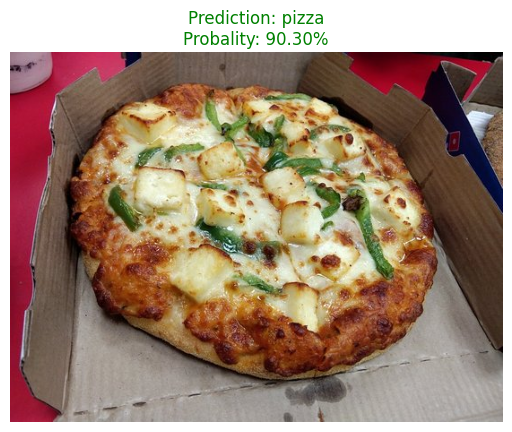

In [61]:
predictions(image_path, finetuneed_model, content)